In [1]:
# Google Driveをマウント
from google.colab import userdata, drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Fitbit

/content/drive/MyDrive/Fitbit


In [10]:
import requests
import json
from datetime import datetime, timedelta

# 設定ファイルのパス
CONFIG_FILE = "token.json"

def load_config():
    """設定ファイルを読み込む"""
    try:
        with open(CONFIG_FILE, "r", encoding="utf-8") as f:
            return json.load(f)
    except FileNotFoundError:
        print(f"設定ファイル {CONFIG_FILE} が見つかりません。")
        exit(1)

def save_config(config):
    """設定ファイルを保存する"""
    with open(CONFIG_FILE, "w", encoding="utf-8") as f:
        json.dump(config, f, indent=2)

def create_auth_header(access_token):
    """認証用のヘッダを作成する"""
    return {"Authorization": "Bearer " + access_token}

def refresh_access_token(config):
    """アクセストークンを更新する"""
    url = "https://api.fitbit.com/oauth2/token"
    params = {
        "grant_type": "refresh_token",
        "refresh_token": config["refresh_token"],
        "client_id": config["client_id"],
    }

    response = requests.post(url, data=params)
    data = response.json()

    if "errors" in data:
        print(f"アクセストークンの更新に失敗しました: {data['errors'][0]['message']}")
        return False

    config["access_token"] = data["access_token"]
    config["refresh_token"] = data["refresh_token"]
    save_config(config)
    return True

def is_token_expired(response_data):
    """アクセストークンの有効期限が切れているかチェックする"""
    if "errors" in response_data:
        for error in response_data["errors"]:
            if error.get("errorType") == "expired_token":
                print("アクセストークンの有効期限が切れています。")
                return True
    return False

def make_api_request(url, headers):
    """APIリクエストを実行する"""
    response = requests.get(url, headers=headers)
    data = response.json()

    if is_token_expired(data):
        config = load_config()
        if refresh_access_token(config):
            headers = create_auth_header(config["access_token"])
            response = requests.get(url, headers=headers)
        else:
            print("アクセストークンの更新に失敗したため、リクエストを中止します。")
            exit(1)

    return response

def get_heart_rate(start_date="today", end_date="today"):
    """心拍数データを取得する"""
    config = load_config()
    headers = create_auth_header(config["access_token"])

    # 日付の妥当性をチェック
    if start_date == "today":
        start_date = datetime.now().strftime("%Y-%m-%d")
    if end_date == "today":
        end_date = datetime.now().strftime("%Y-%m-%d")

    start_date_obj = datetime.strptime(start_date, "%Y-%m-%d")
    end_date_obj = datetime.strptime(end_date, "%Y-%m-%d")

    if start_date_obj > end_date_obj:
        raise ValueError("start_date must be earlier than or equal to end_date")

    if (end_date_obj - start_date_obj).days > 365:
        raise ValueError("Maximum range is 1 year")

    url = f"https://api.fitbit.com/1/user/-/activities/heart/date/{start_date}/{end_date}.json"
    return make_api_request(url, headers)

if __name__ == "__main__":
    response = get_heart_rate(start_date="2024-03-01", end_date="today")
    _data = response.json()
    #print(json.dumps(data, indent=2))
    print(json.dumps(_data["activities-heart"], indent=2))

[
  {
    "dateTime": "2024-03-01",
    "value": {
      "customHeartRateZones": [],
      "heartRateZones": [
        {
          "caloriesOut": 2561.7088,
          "max": 115,
          "min": 30,
          "minutes": 1423,
          "name": "Out of Range"
        },
        {
          "caloriesOut": 112.19400000000002,
          "max": 140,
          "min": 115,
          "minutes": 16,
          "name": "Fat Burn"
        },
        {
          "caloriesOut": 8.0216,
          "max": 172,
          "min": 140,
          "minutes": 1,
          "name": "Cardio"
        },
        {
          "caloriesOut": 0,
          "max": 220,
          "min": 172,
          "minutes": 0,
          "name": "Peak"
        }
      ],
      "restingHeartRate": 64
    }
  },
  {
    "dateTime": "2024-03-02",
    "value": {
      "customHeartRateZones": [],
      "heartRateZones": [
        {
          "caloriesOut": 1725.1860000000001,
          "max": 115,
          "min": 30,
          "minutes"

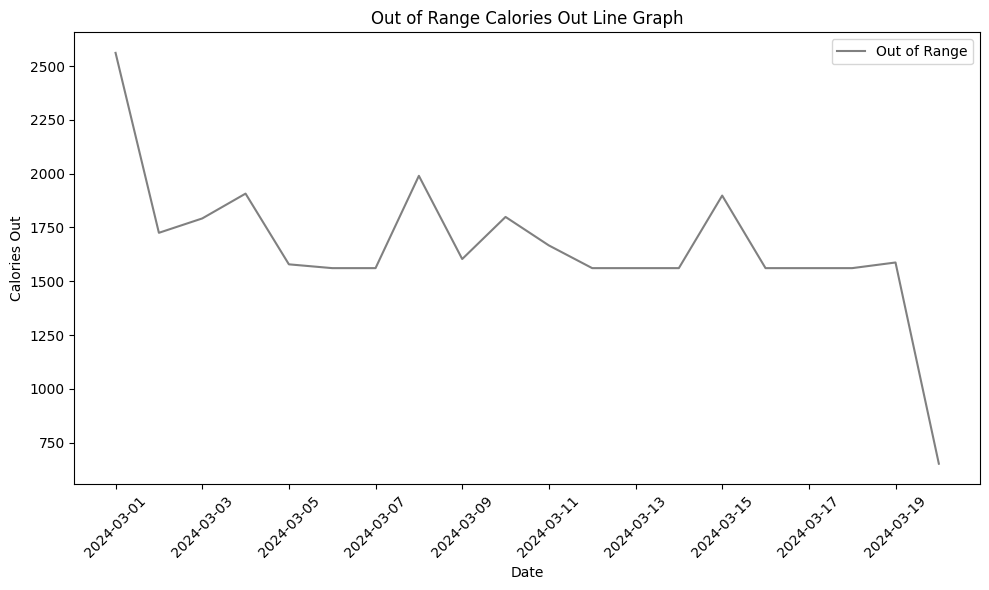

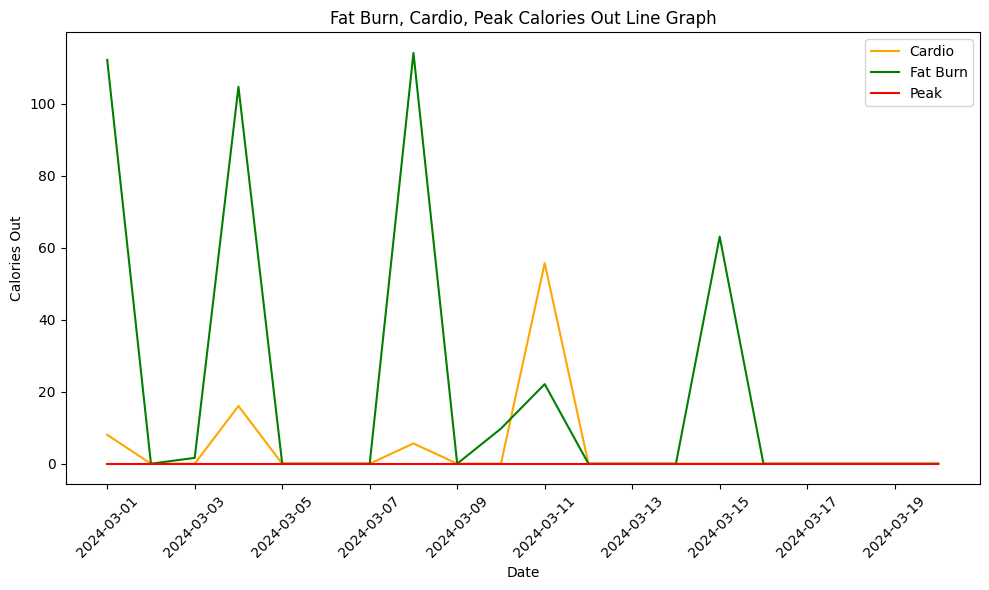

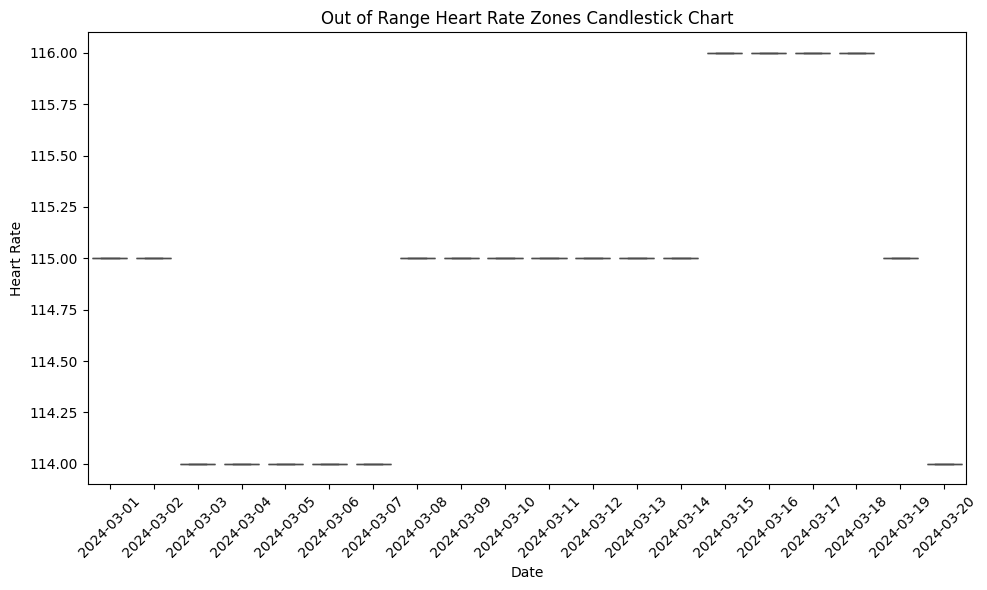

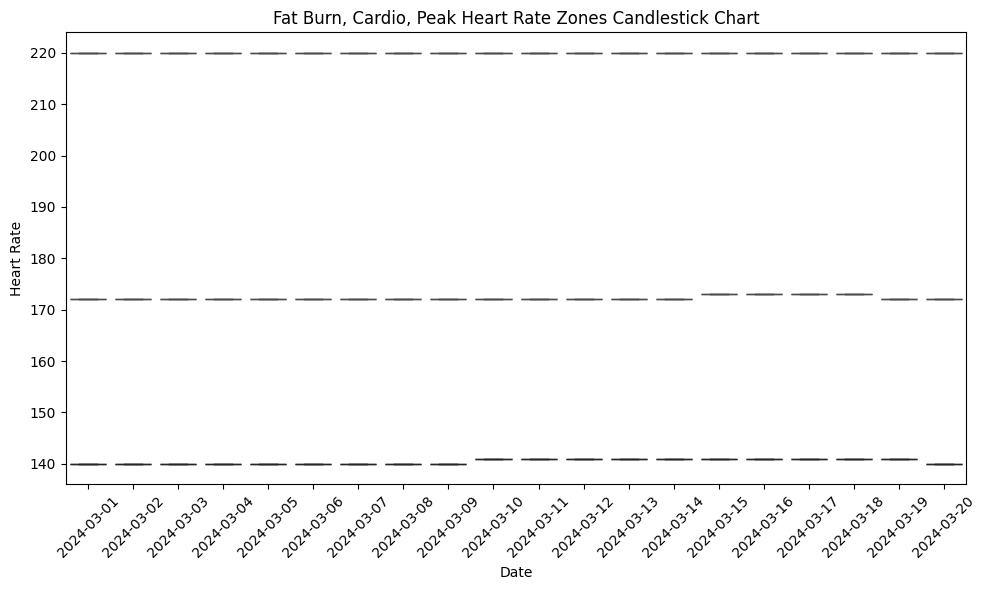

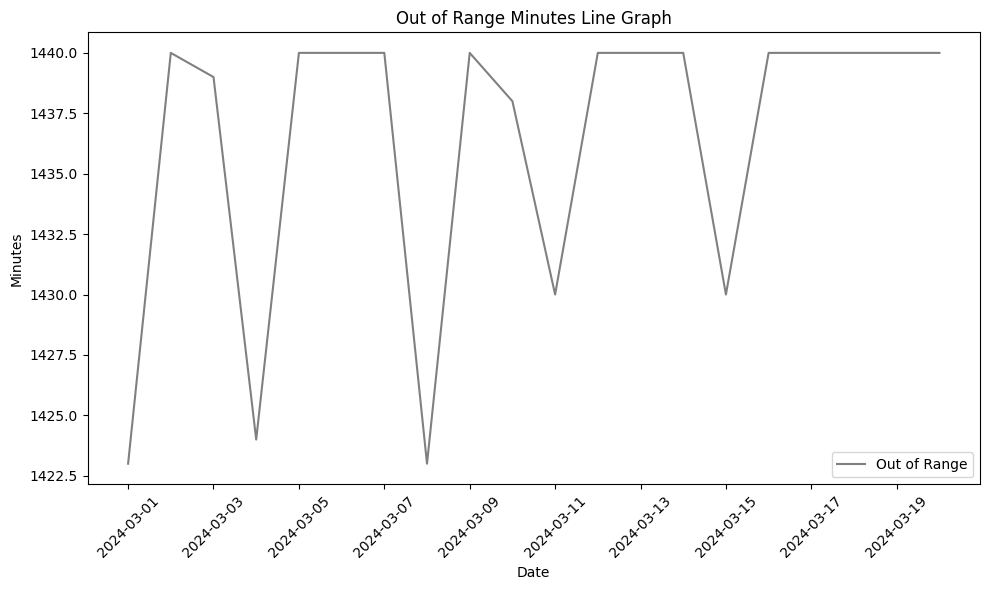

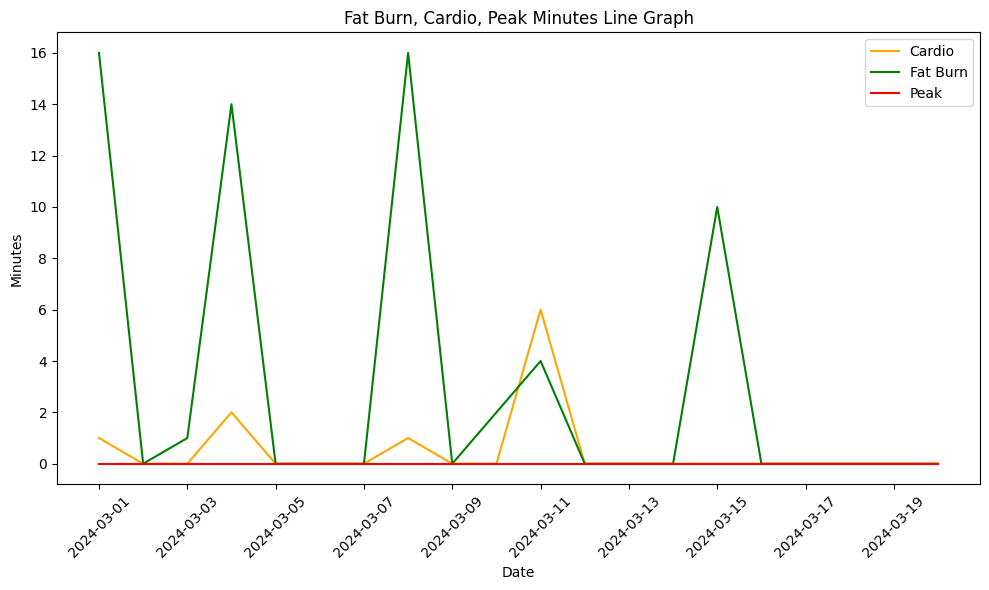

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = _data["activities-heart"]

# データをDataFrameに変換
df = pd.DataFrame([
    {
        'dateTime': d['dateTime'],
        'name': z['name'],
        'caloriesOut': z['caloriesOut'],
        'max': z['max'],
        'min': z['min'],
        'minutes': z['minutes']
    }
    for d in data
    for z in d['value']['heartRateZones']
])

# DateTimeをパースし、indexに設定
df['dateTime'] = pd.to_datetime(df['dateTime'])
df.set_index('dateTime', inplace=True)

# カラーマップの定義
color_map = {
    'Out of Range': 'gray',
    'Fat Burn': 'green',
    'Cardio': 'orange',
    'Peak': 'red'
}

# Out of Rangeの折れ線グラフ
plt.figure(figsize=(10, 6))
out_of_range_df = df[df['name'] == 'Out of Range']
sns.lineplot(data=out_of_range_df, x=out_of_range_df.index, y='caloriesOut', label='Out of Range', color=color_map['Out of Range'])
plt.title('Out of Range Calories Out Line Graph')
plt.xlabel('Date')
plt.ylabel('Calories Out')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Fat Burn, Cardio, PeakのcaloriesOutの折れ線グラフ
plt.figure(figsize=(10, 6))
for name, group in df[df['name'] != 'Out of Range'].groupby('name'):
    sns.lineplot(data=group, x=group.index, y='caloriesOut', label=name, color=color_map[name])
plt.title('Fat Burn, Cardio, Peak Calories Out Line Graph')
plt.xlabel('Date')
plt.ylabel('Calories Out')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Out of Rangeのmin とMaxのキャンドルチャート
plt.figure(figsize=(10, 6))
sns.boxplot(data=out_of_range_df, x=out_of_range_df.index, y='max', color=color_map['Out of Range'])
plt.title('Out of Range Heart Rate Zones Candlestick Chart')
plt.xlabel('Date')
plt.ylabel('Heart Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Fat Burn, Cardio, Peakのmin とMaxのキャンドルチャート
plt.figure(figsize=(10, 6))
for name, group in df[df['name'] != 'Out of Range'].groupby('name'):
    sns.boxplot(data=group, x=group.index, y='max', color=color_map[name])
plt.title('Fat Burn, Cardio, Peak Heart Rate Zones Candlestick Chart')
plt.xlabel('Date')
plt.ylabel('Heart Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Out of Rangeのminutesの折れ線グラフ
plt.figure(figsize=(10, 6))
sns.lineplot(data=out_of_range_df, x=out_of_range_df.index, y='minutes', label='Out of Range', color=color_map['Out of Range'])
plt.title('Out of Range Minutes Line Graph')
plt.xlabel('Date')
plt.ylabel('Minutes')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Fat Burn, Cardio, Peakのminutesの折れ線グラフ
plt.figure(figsize=(10, 6))
for name, group in df[df['name'] != 'Out of Range'].groupby('name'):
    sns.lineplot(data=group, x=group.index, y='minutes', label=name, color=color_map[name])
plt.title('Fat Burn, Cardio, Peak Minutes Line Graph')
plt.xlabel('Date')
plt.ylabel('Minutes')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
df

,name,caloriesOut,max,min,minutes
dateTime,,,,,
2024-03-01,Out of Range,2561.7088,115,30,1423
2024-03-01,Fat Burn,112.1940,140,115,16
2024-03-01,Cardio,8.0216,172,140,1
2024-03-01,Peak,0.0000,220,172,0
2024-03-02,Out of Range,1725.1860,115,30,1440
...,...,...,...,...,...
2024-03-19,Peak,0.0000,220,172,0
2024-03-20,Out of Range,651.7008,114,30,1440
2024-03-20,Fat Burn,0.0000,140,114,0
